# SciFi Convention Maps

In an effort to determine the density of science fiction fans in Texas, I scraped data from Wikipedia's page "List of Science Fiction Conventions".  After slicing out the Texas conventions, I want to do a few things:  
*  I want to make a map with the convention locations.  One would expect the conventions to fall primarily in the major cities, so to highlight the role of conventions in smaller towns, I want to find a way to normalize by the immediate population.  
*  To examine the role of conventions in smaller areas, I want to include a county-by-county map of Texas, scaling the number of conventions in a county by that county's population. 

In [433]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import pandas as pd
from pandas import DataFrame
from geopy.geocoders import Nominatim
%matplotlib inline

In [407]:
mpl.rcParams['font.size'] = 16.
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.labelsize'] = 10.
mpl.rcParams['xtick.labelsize'] = 12.
mpl.rcParams['ytick.labelsize'] = 12.

In [408]:
condata=pd.read_csv('TexasCons.csv')

In [409]:
plotdata = condata.Location.value_counts()

In [410]:
plotdata

Dallas, Texas             4
Austin, Texas             2
College Station, Texas    1
Houston, Texas            1
McKinney, Texas           1
Name: Location, dtype: int64

#### As we can see in our data, some cities have multiple conventions.  To include this information, I will scale the map marker sizes by the number of conventions in that city.

In [411]:
placedict = {}

In [412]:
placedict = dict(list(condata.groupby('Location')))

In [532]:
list(placedict['Austin, Texas'].County)

['Travis', 'Travis']

In [534]:
newlats = []
newlons = []
counties = []

In [535]:
for spot in plotdata.keys():
    mess = list(placedict[spot].Coordinates)
    cmess = list(placedict[spot].County)
    counties.append(cmess[0])
    sep = mess[0].strip('[]').split(',')
    newlats.append(sep[0])
    newlons.append(sep[1])

In [415]:
df = DataFrame(plotdata, index=[plotdata.keys()])

In [536]:
df['Lat']=newlats
df['Long']=newlons
df['County']=counties

In [537]:
df

,Location,Lat,Long,County
"Dallas, Texas",4,32.7762719,-96.7968558,Dallas
"Austin, Texas",2,30.2711286,-97.7436994,Travis
"College Station, Texas",1,30.6262616,-96.3347248,Brazos
"Houston, Texas",1,29.7589382,-95.3676973,Harris
"McKinney, Texas",1,33.1976496,-96.615447,Collin


In [498]:
lllat = 25; urlat = 37; lllon = -107; urlon = -93

In [419]:
cpalette = DataFrame({'darker': [50,256,150], 'dark':[13,177,75], 'med':[107,192,113], 'light':[157,210,155],'pale':[204,230,202]}, index=['R','G','B'])

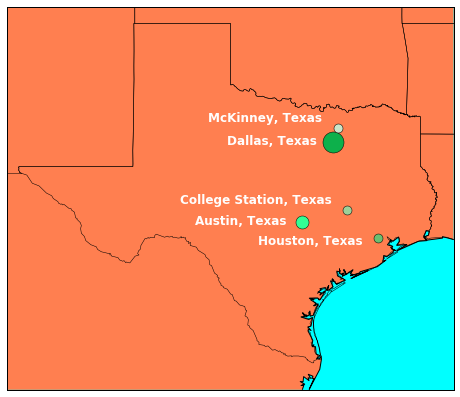

In [506]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
map = Basemap(ax=ax,lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua',zorder=0)
map.drawcoastlines()
#map.drawcountries()
#map.readshapefile('./tl_2013_48_cousub/tl_2013_48_cousub', 'counties')
map.readshapefile('./states_21basic/states','states')
for i,loc in enumerate(df.index):
    x = float(df.Long[i])
    y = float(df.Lat[i])
    r, g, b = cpalette.iloc[:,i]/256
    size = 5 + df.Location[i]*4
    map.plot(x,y,marker='o',color=[r,g,b],ms=size)
    
    tx = float(df.Long[i])-0.5
    ty = float(df.Lat[i])-0.2
    if i == 2 or i == 4:  ty = ty + 0.3
    if i == 3:  ty = ty - 0.1
    plt.text(tx, ty, df.index[i],fontsize=12,fontweight='bold',
                    ha='right',va='bottom',color='w')
plt.savefig('TexasCons.pdf',bbox_inches='tight')

Now, to do the county colors, I either need more data with populations, or I should redo the same map as above but with all US locations.  Replicating the US would probably be faster & easier, since I already have everything I need.

In [421]:
USdata=pd.read_csv('USACons.csv')

In [428]:
USdata.columns=['ind','Conv','Loc','USA','type','web','date']

In [429]:
USdata[:5]

,ind,Conv,Loc,USA,type,web,date
0,2,AggieCon,"College Station, Texas",USA,General,http://aggiecon.tamu.edu/,2016-04-01
1,3,Albacon,"Albany, New York",USA,SF/F,http://www.albacon.org/,2016-03-04
2,4,All-Con,"Dallas, Texas",USA,General,http://www.all-con.net,2016-03-17
3,5,ApolloCon,"Houston, Texas",USA,General,http://www.apollocon.org,2015-06-19
4,6,Archon,"St. Louis, Missouri",USA,General,http://www.archonstl.org/,2015-10-02


In [430]:
USplotdata = USdata.Loc.value_counts()

In [434]:
geolocator = Nominatim()

In [440]:
USlon = []
USlat = []
for spot in USplotdata.keys():
    if 'Various' in spot:
        USlat.append('')
        USlon.append('')
    else:
        location = geolocator.geocode(spot)
        USlat.append(location.latitude)
        USlon.append(location.longitude)

In [481]:
USdf = DataFrame(USplotdata, index=[USplotdata.keys()])
USdf['Lat'] = USlat
USdf['Lon'] = USlon
USdf['Lat_m'] = float(Basemap(USlat))

TypeError: float() argument must be a string or a number, not 'Basemap'

In [483]:
print(Basemap(USlat[0]))

In [480]:
USdf[:5]

,Loc,Lat,Lon,Lat_m
"Atlanta, Georgia",6,33.7491,-84.3902,<mpl_toolkits.basemap.Basemap object at 0x1314...
"Dallas, Texas",4,32.7763,-96.7969,<mpl_toolkits.basemap.Basemap object at 0x1314...
"Los Angeles, California",3,34.0544,-118.244,<mpl_toolkits.basemap.Basemap object at 0x1314...
"Indianapolis, Indiana",3,39.7683,-86.1584,<mpl_toolkits.basemap.Basemap object at 0x1314...
"Bloomington, Minnesota",2,44.8322,-93.3205,<mpl_toolkits.basemap.Basemap object at 0x1314...


In [500]:
lat_1 = 25; lat_2 = 50; lon_0 = -97; lat_0 = 38.88

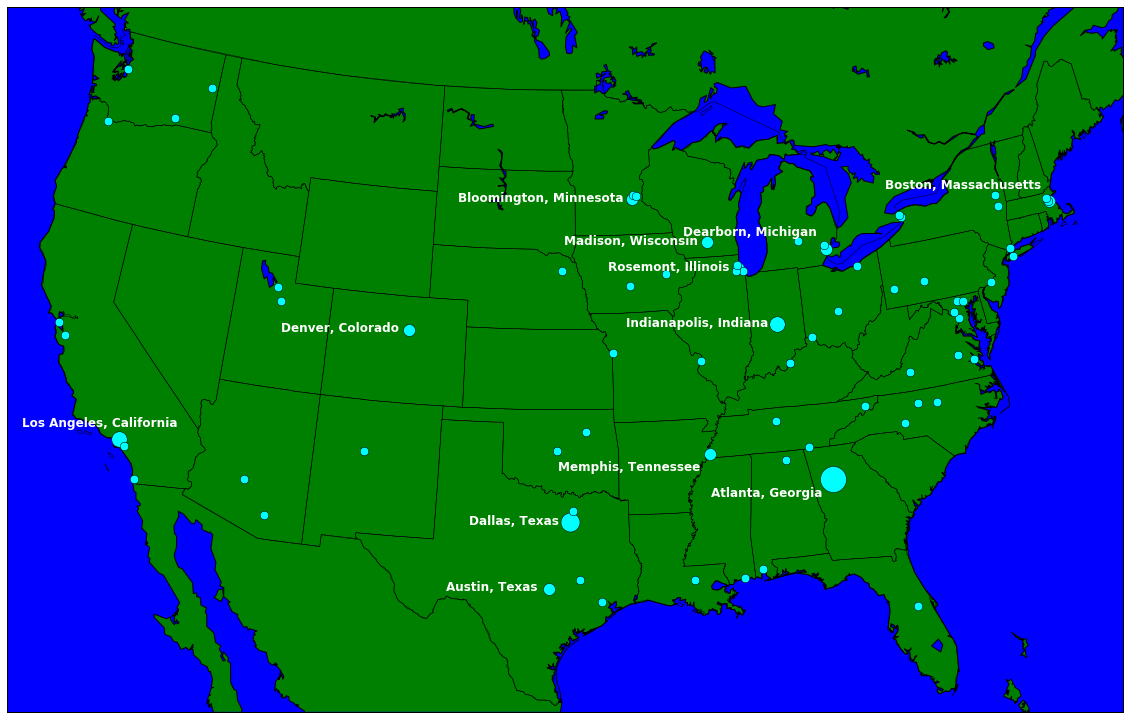

In [507]:
fig2 = plt.figure(figsize=(20,20))
ax = fig2.add_subplot(111)
m = Basemap(width=4750000,height=3000000,
            resolution='l',projection='aea',\
            lat_1=lat_1,lat_2=lat_2,lon_0=lon_0,lat_0=lat_0)
m.drawmapboundary(fill_color='blue')
m.fillcontinents(color='g',lake_color='blue',zorder=0)
m.drawcoastlines()
m.drawcountries()
m.readshapefile('./states_21basic/states','states')
for i,loc in enumerate(USdf.index):
    if 'Various' not in loc:
        x, y = m(float(USdf.Lon[i]),float(USdf.Lat[i]))
        size = 5 + USdf.Loc[i]*3.5
        m.plot(x,y,marker='o',color='aqua',ms=size)
        if USdf.Loc[i] > 1:
            tx, ty = m(float(USdf.Lon[i])-0.5, float(USdf.Lat[i])-0.2)
            if 'Boston' in USdf.index[i] or 'Dearborn' in USdf.index[i]:  ty = ty + 70000
            if 'Atlanta' in USdf.index[i] or 'Memphis' in USdf.index[i]:  ty = ty - 60000
            if 'Angeles' in USdf.index[i]:
                tx = tx + 300000
                ty = ty + 50000
            plt.text(tx, ty, USdf.index[i],fontsize=12,fontweight='bold',
                    ha='right',va='bottom',color='w')
plt.savefig('USAcons.pdf',bbox_inches='tight')

In [508]:
connums = np.array([4,2,1,1,1])

In [522]:
coupop = np.array([2.48,1.121000,.203164,4.337,.854778])

In [523]:
connums/coupop

array([ 1.61290323,  1.78412132,  4.92213187,  0.23057413,  1.16989441])

This is what I want to normalize the color of the counties.  # conventions per person.  To find this, I need to scrape for county populations, then make shape patches colored by that.  I want a smooth scale from 0-5, so most of texas will be the same color (0), and the five locations will pop out.

In [525]:
countypop = pd.read_csv('2013_txpopest_county.csv')

In [560]:
pop = []

In [561]:
for cou in df['County']:
    for i,line in enumerate(countypop.county):
        if cou == line: pop.append(countypop.jan1_2014_pop_est[i])

In [563]:
df['Pop']=pop

In [559]:
df

,Location,Lat,Long,County,Pop
"Dallas, Texas",4,32.7762719,-96.7968558,Dallas,2474550
"Austin, Texas",2,30.2711286,-97.7436994,Travis,1126684
"College Station, Texas",1,30.6262616,-96.3347248,Brazos,204362
"Houston, Texas",1,29.7589382,-95.3676973,Harris,4365601
"McKinney, Texas",1,33.1976496,-96.615447,Collin,867308


In [564]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

Anderson
Andrews
Angelina
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Aransas
Archer
Armstrong
Atascosa
Austin
Bailey
Bandera
Bastrop
Baylor
Bee
Bell
Bexar
Blanco
Borden
Bosque
Bowie
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazoria
Brazo

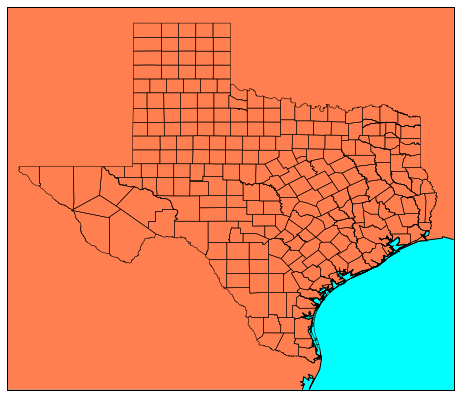

In [617]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
lllat = 25; urlat = 37; lllon = -107; urlon = -93
map = Basemap(ax=ax,lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua',zorder=0)
map.drawcoastlines()
map.readshapefile('./Counties/Counties', 'counties',zorder=3)
#map.readshapefile('./states_21basic/states','states')
#for i,loc in enumerate(df.index):
#    x = float(df.Long[i])
#    y = float(df.Lat[i])
#    r, g, b = cpalette.iloc[:,i]/256
#    size = 5 + df.Location[i]*4
#    map.plot(x,y,marker='o',color=[r,g,b],ms=size)

patches   = []

for info, shape in zip(map.counties_info, map.counties):
    for couname in df.County:
        if info['Name'] == couname:
            print("Found one!")
        for i,loc in enumerate(df.County):
            if info['NAME'] == loc:
                patches.append( Polygon(np.array(shape), True) )
                print("Appended shape.")
        
ax.add_collection(PatchCollection(patches, facecolor= 'm', edgecolor='k', linewidths=1., zorder=10))
   
#    tx = float(df.Long[i])-0.5
#    ty = float(df.Lat[i])-0.2
#    if i == 2 or i == 4:  ty = ty + 0.3
#    if i == 3:  ty = ty - 0.1
#    plt.text(tx, ty, df.index[i],fontsize=12,fontweight='bold',
#                    ha='right',va='bottom',color='w')
#plt.savefig('TexasCons.pdf',bbox_inches='tight')

In [621]:
map.counties_info[99]['Name']

'Brazoria'

In [581]:
findname = [info['NAME'] for info in map.counties_info if info['NAME'] in df.County ]

In [582]:
findname

[]

In [606]:
namelist = []
for realnames in df.County:
    for info in map.counties_info:
        if realnames in info['NAME']:
            namelist.append(info['NAME'])
#    if info['NAME'] == 'Grayson':
#        print('Found!')

In [603]:
namelist.sort()

In [607]:
namelist

['Northeast Dallas',
 'Southwest Dallas',
 'Southwest Travis',
 'Northeast Travis',
 'Northwest Travis',
 'Brazosport',
 'South Brazos',
 'Northeast Brazos',
 'West Brazos',
 'Northeast Harris',
 'Southeast Harris',
 'Northwest Harris']

In [591]:
def namer(infofile):
    return infofile['NAME']

In [593]:
sortnames = sorted(map.counties_info,key=namer)

In [594]:
sortnames

[{'ALAND': 607833115,
  'AWATER': 132501,
  'CLASSFP': 'Z5',
  'CNECTAFP': b'   ',
  'COUNTYFP': '189',
  'COUSUBFP': '90005',
  'COUSUBNS': '01938476',
  'FUNCSTAT': 'S',
  'GEOID': '4818990005',
  'INTPTLAT': '+33.9097905',
  'INTPTLON': '-101.9100343',
  'LSAD': '22',
  'MTFCC': 'G4040',
  'NAME': 'Abernathy',
  'NAMELSAD': 'Abernathy CCD',
  'NCTADVFP': b'     ',
  'NECTAFP': b'     ',
  'RINGNUM': 1,
  'SHAPENUM': 534,
  'STATEFP': '48'},
 {'ALAND': 489552270,
  'AWATER': 4270556,
  'CLASSFP': 'Z5',
  'CNECTAFP': b'   ',
  'COUNTYFP': '441',
  'COUSUBFP': '90010',
  'COUSUBNS': '01938477',
  'FUNCSTAT': 'S',
  'GEOID': '4844190010',
  'INTPTLAT': '+32.4242298',
  'INTPTLON': '-099.7469645',
  'LSAD': '22',
  'MTFCC': 'G4040',
  'NAME': 'Abilene',
  'NAMELSAD': 'Abilene CCD',
  'NCTADVFP': b'     ',
  'NECTAFP': b'     ',
  'RINGNUM': 1,
  'SHAPENUM': 659,
  'STATEFP': '48'},
 {'ALAND': 601617843,
  'AWATER': 156521,
  'CLASSFP': 'Z5',
  'CNECTAFP': b'   ',
  'COUNTYFP': '281',
  '

In [608]:
df.County

Dallas, Texas             Dallas
Austin, Texas             Travis
College Station, Texas    Brazos
Houston, Texas            Harris
McKinney, Texas           Collin
Name: County, dtype: object